In [3]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy.ndimage as ndimage
import pymannkendall as mk

In [4]:
# importing data
# numpy array with columns of date/time and num_value

PC_0192_details = pd.read_csv("Details_PC-0192.csv", sep=',')
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,10/01/2017 18:00,1,1,28/12/2016 18:00,5,11/01/2017 14:00,FLAMI


In [5]:
# changing required fields to correct datetime data type to avoid string issues

PC_0192_details['failed_extubation_deid_date'] = pd.to_datetime(PC_0192_details['failed_extubation_deid_date'], format='%d/%m/%Y %H:%M')
PC_0192_details['re_intubation_deid_date'] = pd.to_datetime(PC_0192_details['re_intubation_deid_date'], format='%d/%m/%Y %H:%M')

In [6]:
failed_extubation = PC_0192_details.iloc[0,8]
re_intubation = PC_0192_details.iloc[0,13]

print(failed_extubation, re_intubation)

2017-01-10 18:00:00 2017-01-11 14:00:00


In [7]:
PC_0192_RR_data = pd.read_csv("PC0192/PC0192_1_RR.csv", sep=',')
PC_0192_RR_data['record_date_time'] = pd.to_datetime(PC_0192_RR_data['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_RR_data


,monitor,record_date_time,num_value
0,RR,2016-12-22 12:09:31,17
1,RR,2016-12-22 12:09:36,18
2,RR,2016-12-22 12:09:41,17
3,RR,2016-12-22 12:09:46,17
4,RR,2016-12-22 12:09:51,17
...,...,...,...
1131421,RR,2017-02-18 17:08:34,36
1131422,RR,2017-02-18 17:08:39,35
1131423,RR,2017-02-18 17:08:44,31
1131424,RR,2017-02-18 17:08:49,30


In [8]:
# finding indexes at which failed_extubation and re_intubation would need to be inserted to maintain order

failed_extubation_index = PC_0192_RR_data.record_date_time.searchsorted(failed_extubation)
re_intubation_index = PC_0192_RR_data.record_date_time.searchsorted(re_intubation)

print(failed_extubation_index, re_intubation_index)

PC_0192_RR_extubated = PC_0192_RR_data.iloc[failed_extubation_index+1:re_intubation_index-1, :]
PC_0192_RR_extubated

436087 450068


,monitor,record_date_time,num_value
436088,RR,2017-01-10 18:00:06,28
436089,RR,2017-01-10 18:00:11,26
436090,RR,2017-01-10 18:00:16,26
436091,RR,2017-01-10 18:00:21,25
436092,RR,2017-01-10 18:00:26,29
...,...,...,...
450062,RR,2017-01-11 13:59:46,36
450063,awRR,2017-01-11 13:59:46,35
450064,RR,2017-01-11 13:59:52,37
450065,awRR,2017-01-11 13:59:52,37


In [9]:
# replacing duplicates with an average value
# only checking slices of the next 30 data points

# for idx1, val1 in enumerate(PC_0192_RR_extubated['record_date_time']):
#     for idx2, val2 in enumerate(PC_0192_RR_extubated['record_date_time'][idx1+1:idx1+50]):
#         if val1 == val2:
#             PC_0192_RR_extubated['num_value'].iloc[idx2] = 0.5*(PC_0192_RR_extubated['num_value'].iloc[idx1]+PC_0192_RR_extubated['num_value'].iloc[idx2])
#             PC_0192_RR_extubated['monitor'].iloc[idx2] = "combination"
#             PC_0192_RR_extubated = PC_0192_RR_extubated.drop(PC_0192_RR_extubated.index[idx1])


In [10]:
# replacing duplicates with an average value
# only checking slices of the next 30 data points

for idx1 in PC_0192_RR_extubated.index:
    for idx2 in range(min(450066, idx1+1), min(450066, idx1+30), 1):
        if PC_0192_RR_extubated['record_date_time'].loc[idx1] == PC_0192_RR_extubated['record_date_time'].loc[idx2]:
            PC_0192_RR_extubated['num_value'].loc[idx2] = 0.5*(PC_0192_RR_extubated['num_value'].loc[idx1]+PC_0192_RR_extubated['num_value'].loc[idx2])
            PC_0192_RR_extubated['monitor'].loc[idx2] = "combination"
            PC_0192_RR_extubated = PC_0192_RR_extubated.drop(idx1, axis=0)
            break
        break

/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
PC_0192_RR_extubated

,monitor,record_date_time,num_value
436088,RR,2017-01-10 18:00:06,28.0
436089,RR,2017-01-10 18:00:11,26.0
436090,RR,2017-01-10 18:00:16,26.0
436091,RR,2017-01-10 18:00:21,25.0
436092,RR,2017-01-10 18:00:26,29.0
...,...,...,...
450059,combination,2017-01-11 13:59:36,39.5
450061,combination,2017-01-11 13:59:42,36.0
450063,combination,2017-01-11 13:59:46,35.5
450065,combination,2017-01-11 13:59:52,37.0


In [12]:
# reindexing

PC_0192_RR_extubated.index = range(13569)

In [13]:
PC_0192_RR_extubated

,monitor,record_date_time,num_value
0,RR,2017-01-10 18:00:06,28.0
1,RR,2017-01-10 18:00:11,26.0
2,RR,2017-01-10 18:00:16,26.0
3,RR,2017-01-10 18:00:21,25.0
4,RR,2017-01-10 18:00:26,29.0
...,...,...,...
13564,combination,2017-01-11 13:59:36,39.5
13565,combination,2017-01-11 13:59:42,36.0
13566,combination,2017-01-11 13:59:46,35.5
13567,combination,2017-01-11 13:59:52,37.0


In [14]:
# smoothing and subtracting to obtain residuals

PC_0192_RR_extubated_smoothed = PC_0192_RR_extubated.copy()
PC_0192_RR_residuals = PC_0192_RR_extubated.copy()
PC_0192_RR_extubated_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_RR_extubated['num_value'], sigma=100)
PC_0192_RR_residuals['num_value'] = PC_0192_RR_extubated['num_value'] - PC_0192_RR_extubated_smoothed['num_value']
PC_0192_RR_residuals

,monitor,record_date_time,num_value
0,RR,2017-01-10 18:00:06,-0.576281
1,RR,2017-01-10 18:00:11,-2.576205
2,RR,2017-01-10 18:00:16,-2.576066
3,RR,2017-01-10 18:00:21,-3.575861
4,RR,2017-01-10 18:00:26,0.424405
...,...,...,...
13564,combination,2017-01-11 13:59:36,10.676829
13565,combination,2017-01-11 13:59:42,7.174808
13566,combination,2017-01-11 13:59:46,6.673293
13567,combination,2017-01-11 13:59:52,8.172280


### Removing anomalies

In [15]:
mu_residual = PC_0192_RR_residuals['num_value'].mean()
sigma_residual = PC_0192_RR_residuals['num_value'].std()

In [16]:
PC_0192_RR_residuals_no_anomalies = PC_0192_RR_residuals.copy()

for idx, val in enumerate(PC_0192_RR_residuals_no_anomalies['num_value']):
    if not (mu_residual - 3*sigma_residual < val < mu_residual + 3*sigma_residual):
        if idx == 0:
            PC_0192_RR_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_RR_residuals['num_value'].iloc[idx+1]
        if idx == 13568:
            PC_0192_RR_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_RR_residuals['num_value'].iloc[idx-1]
        else:
            # PC_0192_RR_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_RR_residuals['num_value'].iloc[idx+1] + PC_0192_RR_residuals['num_value'].iloc[idx-1])
            PC_0192_RR_residuals_no_anomalies['num_value'].iloc[idx] = mu_residual

/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Functions

In [45]:
def rolling_mean(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    global df

    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','mean'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        mean = data['num_value'][index_1:index_2].mean()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['mean']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['mean'] = pd.to_numeric(df['mean'])

    df.plot(x='start_time', y='mean', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['mean'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['mean'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['mean'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['mean'])}")


In [46]:
def rolling_variance(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'variance'
    time - size of window in minutes
    """
    global df

    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','variance'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        var = data['num_value'][index_1:index_2].var()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['variance']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['variance'] = pd.to_numeric(df['variance'])

    df.plot(x='start_time', y='variance', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the variance is {stats.kendalltau(df['start_time'], df['variance'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['variance'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['variance'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['variance'])}")


In [47]:
def rolling_autocorrelation(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    global df

    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.5934389792941863, and the p-value is 1.948734245190851e-187.
The Hamid and Rao correction relusts in a p-value of 9.115634002276884e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=9.115634002276884e-05, z=3.9130005153570204, Tau=0.5935434043867779, s=345834.0, var_s=7811115398.123599, slope=0.01715539273383239, intercept=23.83980074924577)


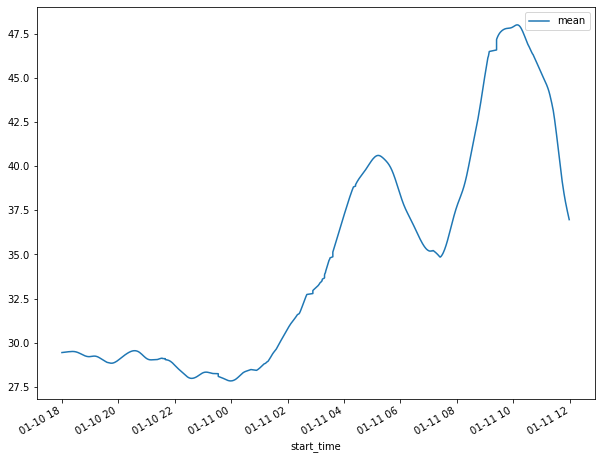

In [20]:
rolling_mean(PC_0192_RR_extubated_smoothed, 120)

The kendall tau correlation coefficient of the variance is 0.7156987801172562, and the p-value is 1.1557293810351141e-271.
The Hamid and Rao correction relusts in a p-value of 4.619969735664142e-07
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=4.619969735664142e-07, z=5.041458533695559, Tau=0.7156626506024096, s=416988.0, var_s=6841205438.978692, slope=0.017098238387907305, intercept=-5.824204837948166)


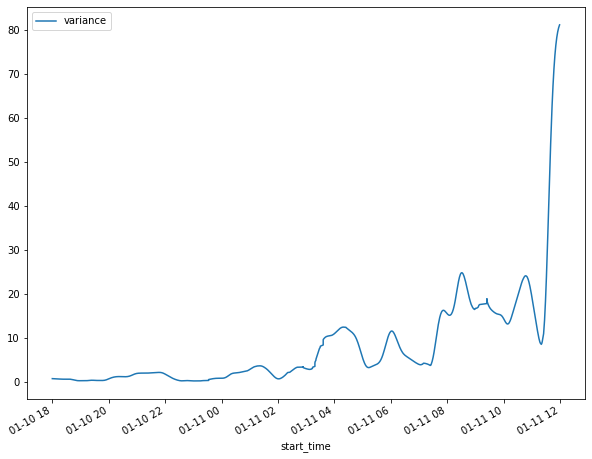

In [21]:
rolling_variance(PC_0192_RR_extubated_smoothed, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.3741575634343535, and the p-value is 1.0879330815720762e-75.
The Hamid and Rao correction relusts in a p-value of 0.0022344626963597403
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0022344626963597403, z=3.0571582578950935, Tau=0.3739436377990595, s=217882.0, var_s=5079288456.766958, slope=2.0000858499540377e-08, intercept=0.9999716801498345)


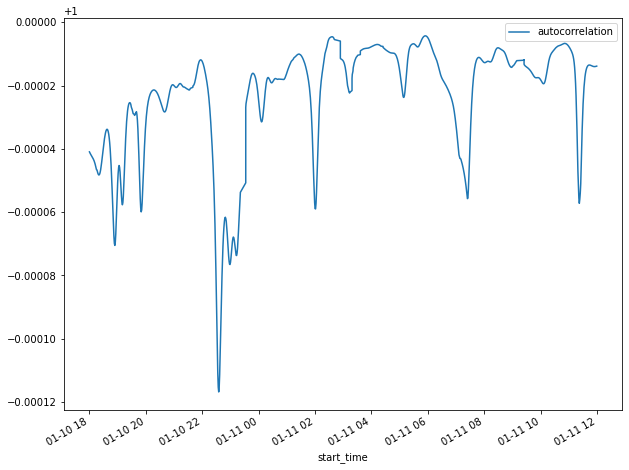

In [22]:
rolling_autocorrelation(PC_0192_RR_extubated_smoothed, 120)

The kendall tau correlation coefficient of the autocorrelation is -0.0001270320873477558, and the p-value is 0.9950128209695474.
The Hamid and Rao correction relusts in a p-value of 0.9965924946596654
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.9965924946596654, z=-0.004270687598000466, Tau=-0.00016819414409775856, s=-98.0, var_s=515879013.7436216, slope=-1.0566857032048468e-07, intercept=-0.004085739607838052)


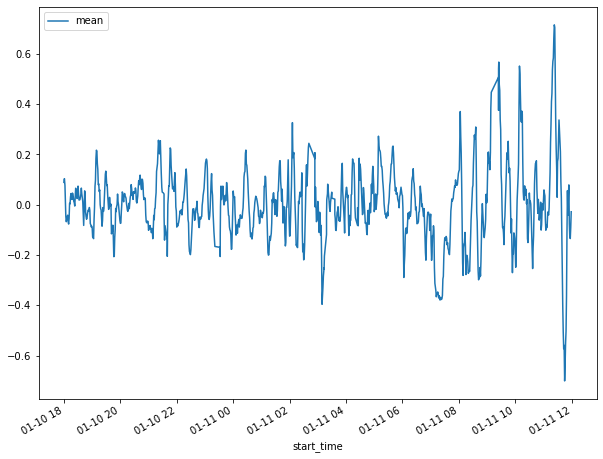

In [23]:
rolling_mean(PC_0192_RR_residuals, 120)

The kendall tau correlation coefficient of the variance is 0.541465689070664, and the p-value is 2.1852830061825449e-156.
The Hamid and Rao correction relusts in a p-value of 2.9969999947532244e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=2.9969999947532244e-05, z=4.173694175322993, Tau=0.5412007002368449, s=315336.0, var_s=5708251608.2727995, slope=0.03767040456680432, intercept=3.0239112834731294)


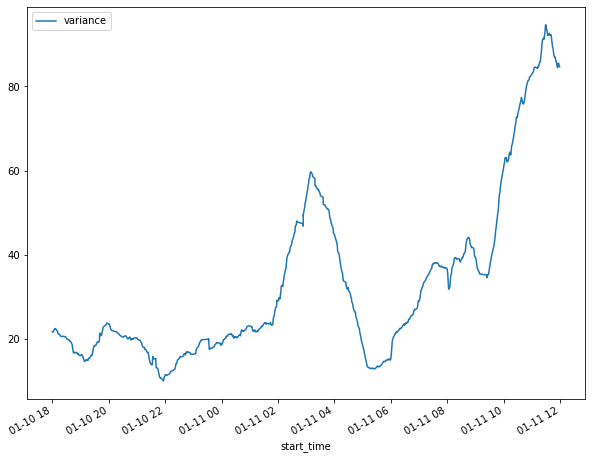

In [24]:
rolling_variance(PC_0192_RR_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the autocorrelation is -0.5162618362809377, and the p-value is 2.3740391008110813e-142.
The Hamid and Rao correction relusts in a p-value of 6.406410802295426e-06
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=6.406410802295426e-06, z=-4.512512664635147, Tau=-0.5163834826485428, s=-300876.0, var_s=4445650723.678237, slope=-0.00016486052824432718, intercept=0.8771977131492932)


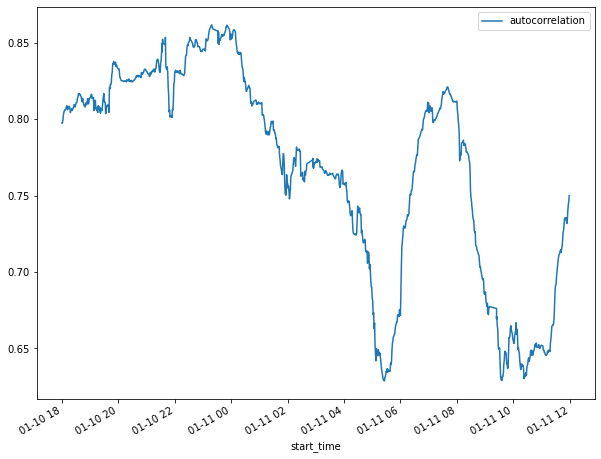

In [25]:
rolling_autocorrelation(PC_0192_RR_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the autocorrelation is -0.07095671071285817, and the p-value is 0.0003339363103830594.
The Hamid and Rao correction relusts in a p-value of 0.41364965784469954
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.41364965784469954, z=-0.8174879061098214, Tau=-0.07076690849159774, s=-45944.0, var_s=3158464704.576462, slope=-1.6790390339755263e-05, intercept=0.841762181968549)


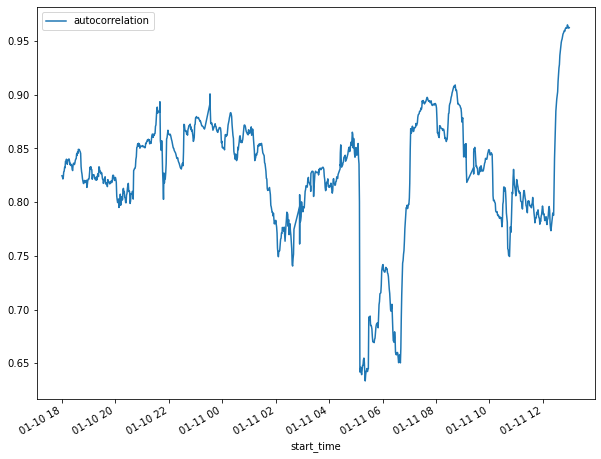

In [26]:
# autocorrelation before detrending

rolling_autocorrelation(PC_0192_RR_extubated, 60)

Lag-2 and lag-3 autocorrelation:

In [27]:
def rolling_autocorrelation_lag_2(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr(lag=2)

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")


In [28]:
def rolling_autocorrelation_lag_3(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr(lag=3)

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")

In [29]:
def rolling_autocorrelation_lag_4(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr(lag=4)

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")

In [30]:
def rolling_autocorrelation_lag_5(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr(lag=5)

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")

In [31]:
def rolling_autocorrelation_lag_6(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr(lag=6)

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")

The kendall tau correlation coefficient of the autocorrelation is -0.07095671071285817, and the p-value is 0.0003339363103830594.
The Hamid and Rao correction relusts in a p-value of 0.41364965784469954
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.41364965784469954, z=-0.8174879061098214, Tau=-0.07076690849159774, s=-45944.0, var_s=3158464704.576462, slope=-1.6790390339755263e-05, intercept=0.841762181968549)


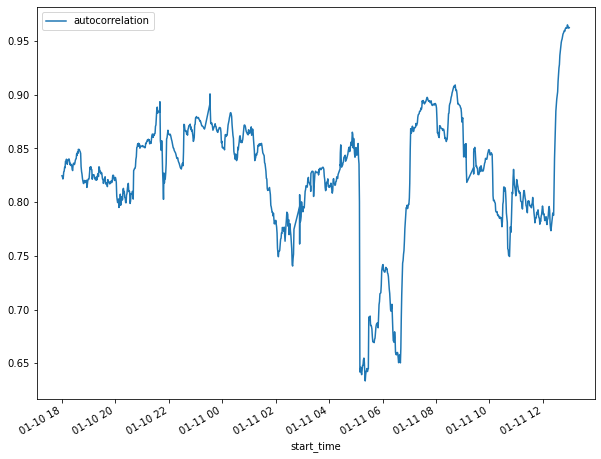

In [32]:
rolling_autocorrelation(PC_0192_RR_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is -0.06795563223640136, and the p-value is 0.0005909940861822832.
The Hamid and Rao correction relusts in a p-value of 0.44212505612289776
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.44212505612289776, z=-0.768609681929592, Tau=-0.06777259214762103, s=-44000.0, var_s=3276980902.55635, slope=-3.262982003853866e-05, intercept=0.6427921032117025)


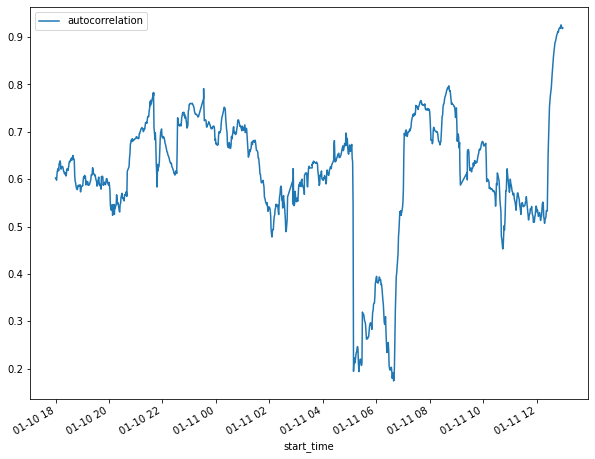

In [33]:
rolling_autocorrelation_lag_2(PC_0192_RR_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.07148051291100772, and the p-value is 0.00030159540585110694.
The Hamid and Rao correction relusts in a p-value of 0.4091848101798514
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.4091848101798514, z=0.8253290381840415, Tau=0.07164179104477612, s=46512.0, var_s=3175828948.8801146, slope=4.9358439972337206e-05, intercept=0.4482416080124272)


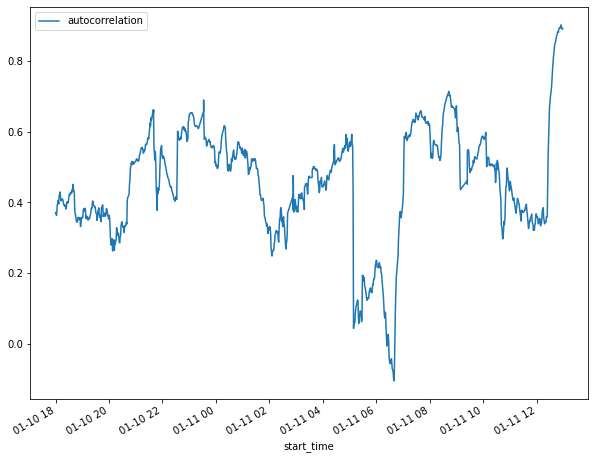

In [34]:
rolling_autocorrelation_lag_3(PC_0192_RR_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.14806963784867394, and the p-value is 7.093207891546539e-14.
The Hamid and Rao correction relusts in a p-value of 0.06142476117857121
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.06142476117857121, z=1.870425445482803, Tau=0.14824330360580995, s=96244.0, var_s=2647631258.7289567, slope=0.00010617211159817325, intercept=0.3269937723750411)


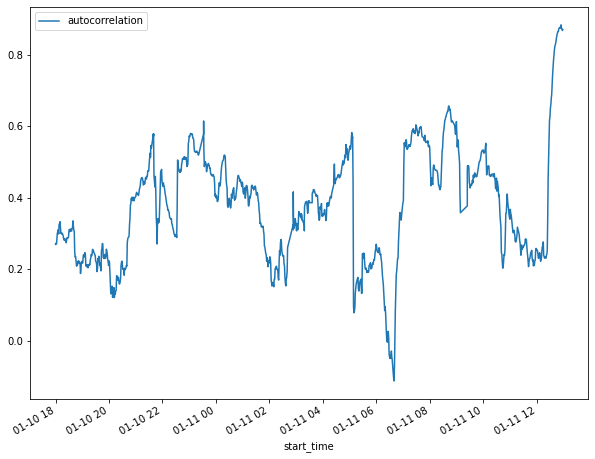

In [35]:
rolling_autocorrelation_lag_4(PC_0192_RR_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.17624403373031775, and the p-value is 5.076607866034898e-19.
The Hamid and Rao correction relusts in a p-value of 0.02968476148876764
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.02968476148876764, z=2.174271366354735, Tau=0.17642437964973892, s=114540.0, var_s=2775104113.422983, slope=0.00013258375830877631, intercept=0.27253474935031774)


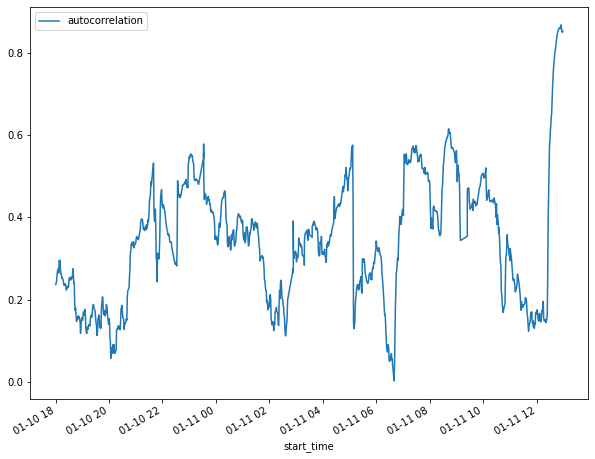

In [36]:
rolling_autocorrelation_lag_5(PC_0192_RR_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.17624403373031775, and the p-value is 5.076607866034898e-19.
The Hamid and Rao correction relusts in a p-value of 0.02968476148876764
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.02968476148876764, z=2.174271366354735, Tau=0.17642437964973892, s=114540.0, var_s=2775104113.422983, slope=0.00013258375830877631, intercept=0.27253474935031774)


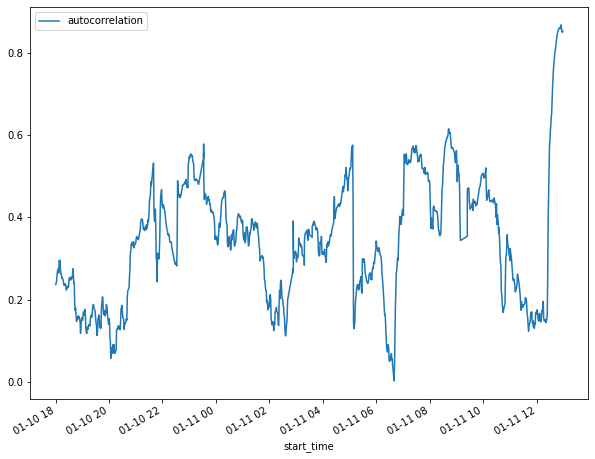

In [37]:
rolling_autocorrelation_lag_5(PC_0192_RR_extubated, 60)

No significant change :(

The kendall tau correlation coefficient of the autocorrelation is -0.342283168164922, and the p-value is 4.2963995188483445e-67.
The Hamid and Rao correction relusts in a p-value of 0.0003303075842644443
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=0.0003303075842644443, z=-3.5902921105307697, Tau=-0.34229471835867104, s=-222228.0, var_s=3831193413.67226, slope=-0.00021187263757618832, intercept=0.667350918593686)


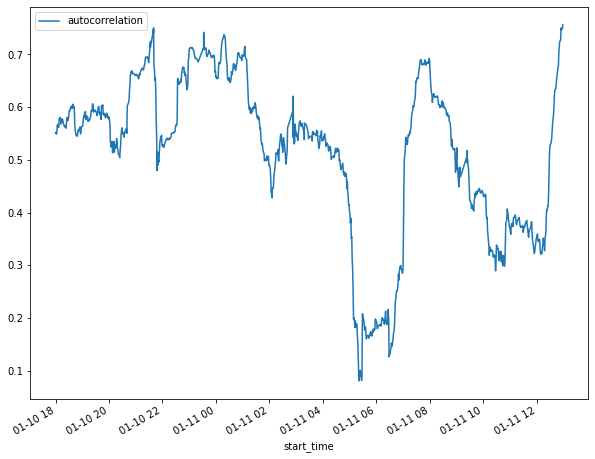

In [38]:
rolling_autocorrelation_lag_2(PC_0192_RR_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the autocorrelation is -0.21389308701966658, and the p-value is 2.9534091048234054e-27.
The Hamid and Rao correction relusts in a p-value of 0.016024408061954487
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=0.016024408061954487, z=-2.4083591545738314, Tau=-0.21379788364678157, s=-138804.0, var_s=3321660174.7234855, slope=-0.0001505136188931201, intercept=0.4364279285580738)


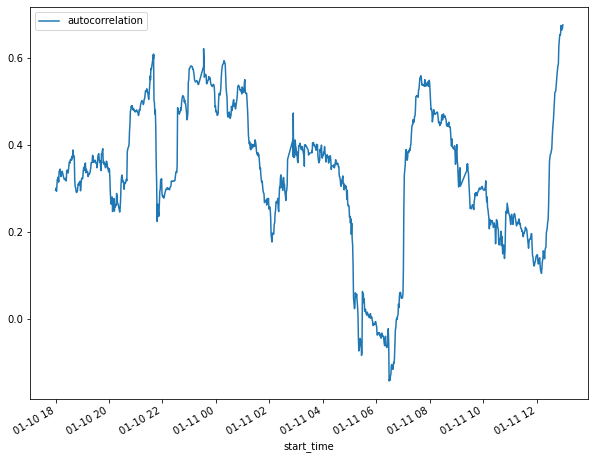

In [39]:
rolling_autocorrelation_lag_3(PC_0192_RR_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the autocorrelation is -0.14676937592150271, and the p-value is 1.167716281016123e-13.
The Hamid and Rao correction relusts in a p-value of 0.09531085440636256
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.09531085440636256, z=-1.6680245449376354, Tau=-0.14667221169693329, s=-95224.0, var_s=3258958616.2991023, slope=-0.00010491832762595062, intercept=0.30208211417817504)


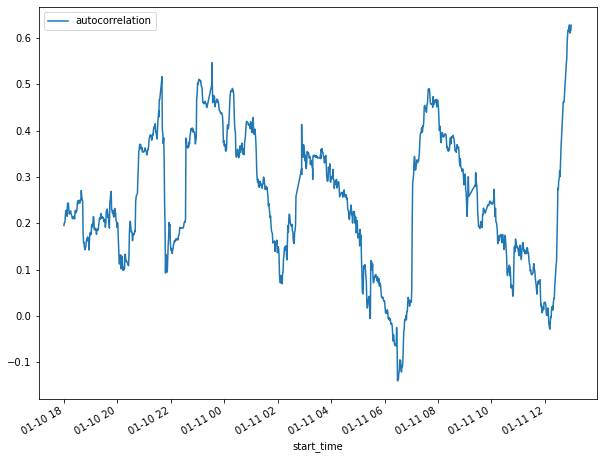

In [40]:
rolling_autocorrelation_lag_4(PC_0192_RR_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the autocorrelation is -0.09581882798855632, and the p-value is 1.2697752105024068e-06.
The Hamid and Rao correction relusts in a p-value of 0.35235641591474476
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.35235641591474476, z=-0.9300283311535048, Tau=-0.09570722240192228, s=-62136.0, var_s=4463548399.253145, slope=-5.751786830923568e-05, intercept=0.22652238586837992)


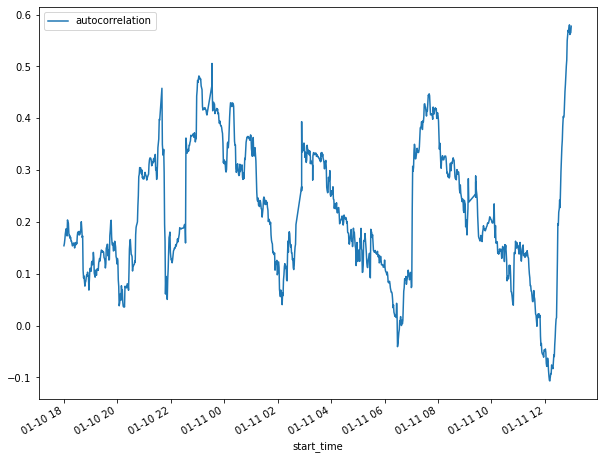

In [41]:
rolling_autocorrelation_lag_5(PC_0192_RR_residuals_no_anomalies, 60)

nothing much here - will not look at lag 2,3,4,5,...

<AxesSubplot:xlabel='record_date_time'>

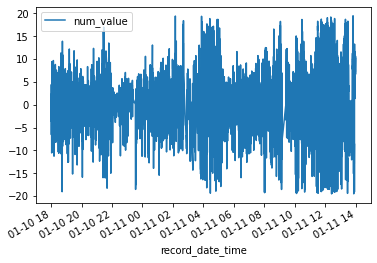

In [42]:
PC_0192_RR_residuals_no_anomalies.plot(x='record_date_time', y='num_value')

In [60]:
def graph_grid(f, data, a, b, c, d, type_of_func):
    """
    Inputs:
    f: function i.e rolling_mean or rolling_variance
    data: 
    a, b, c, d: 4 options for length of time windows in minutes
    type_of_funct = mean, var or ac
    units = 
    """

    time = [a, b, c, d]

    # if type_of_func == 'mean':
    #     y_lab = "Mean (BPM)"
    #     typ = "mean"
    # if type_of_func == 'variance':
    #     y_lab = "Variance (BPM^2)"
    #     typ = "variance"
    # if type_of_func == 'autocorrelation':
    #     y_lab = "Autocorrelation"
    #     typ = "autocorrelation"

    mean_df_list = []
    rolling_mean(data, time[0])
    mean_df_list.append(df)
    rolling_mean(data, time[1])
    mean_df_list.append(df)
    rolling_mean(data, time[2])
    mean_df_list.append(df)
    rolling_mean(data, time[3])
    mean_df_list.append(df)

    var_df_list = []
    rolling_variance(data, time[0])
    var_df_list.append(df)
    rolling_variance(data, time[1])
    var_df_list.append(df)
    rolling_variance(data, time[2])
    var_df_list.append(df)
    rolling_variance(data, time[3])
    var_df_list.append(df)

    ac_df_list = []
    rolling_autocorrelation(data, time[0])
    ac_df_list.append(df)
    rolling_autocorrelation(data, time[1])
    ac_df_list.append(df)
    rolling_autocorrelation(data, time[2])
    ac_df_list.append(df)
    rolling_autocorrelation(data, time[3])
    ac_df_list.append(df)

    # fig, axs = plt.subplots(2, 2, figsize=(20,16))
    
    # axs[0, 0].plot(df['start_time'], df[typ])
    # axs[0, 0].set_title('30 minutes')

    # f(data, time[1])
    # axs[0, 1].plot(df['start_time'], df[typ], 'tab:orange')
    # axs[0, 1].set_title('60 minutes')

    # f(data, time[2])
    # axs[1, 0].plot(df['start_time'], df[typ], 'tab:green')
    # axs[1, 0].set_title('90 minutes')

    # f(data, time[3])
    # axs[1, 1].plot(df['start_time'], df[typ], 'tab:red')
    # axs[1, 1].set_title('120 minutes')

    fig, axs = plt.subplots(1, 3, figsize=(32,8), sharex=True,sharey=False)

    plt.rcParams['font.size'] = '16'
    fig.autofmt_xdate()

    # axs[0, 0].cla()
    axs[0].plot(mean_df_list[0]['start_time'], mean_df_list[0]['mean'], 'tab:blue', label="30 minutes")
    # f(data, time[1])
    axs[0].plot(mean_df_list[1]['start_time'], mean_df_list[1]['mean'], 'tab:orange', label="60 minutes")
    # f(data, time[2])
    axs[0].plot(mean_df_list[2]['start_time'], mean_df_list[2]['mean'], 'tab:green', label="90 minutes")
    # f(data, time[3])
    axs[0].plot(mean_df_list[3]['start_time'], mean_df_list[3]['mean'], 'tab:red', label="120 minutes")
    # axs[0].legend()
    axs[0].set(xlabel='Time (day-month hour)', ylabel="Mean (BPM)")

    axs[1].plot(var_df_list[0]['start_time'], var_df_list[0]['variance'], 'tab:blue', label="30 minutes")
    # f(data, time[1])
    axs[1].plot(var_df_list[1]['start_time'], var_df_list[1]['variance'], 'tab:orange', label="60 minutes")
    # f(data, time[2])
    axs[1].plot(var_df_list[2]['start_time'], var_df_list[2]['variance'], 'tab:green', label="90 minutes")
    # f(data, time[3])
    axs[1].plot(var_df_list[3]['start_time'], var_df_list[3]['variance'], 'tab:red', label="120 minutes")
    # axs[1].legend()
    axs[1].set(xlabel='Time (day-month hour)', ylabel="Variance (BPM^2)")

    axs[2].plot(ac_df_list[0]['start_time'], ac_df_list[0]['autocorrelation'], 'tab:blue', label="30 minutes")
    # f(data, time[1])
    axs[2].plot(ac_df_list[1]['start_time'], ac_df_list[1]['autocorrelation'], 'tab:orange', label="60 minutes")
    # f(data, time[2])
    axs[2].plot(ac_df_list[2]['start_time'], ac_df_list[2]['autocorrelation'], 'tab:green', label="90 minutes")
    # f(data, time[3])
    axs[2].plot(ac_df_list[3]['start_time'], ac_df_list[3]['autocorrelation'], 'tab:red', label="120 minutes")
    # axs[2].legend()
    axs[2].set(xlabel='Time (day-month hour)', ylabel="Autocorrelation")

The kendall tau correlation coefficient of the autocorrelation is 0.22095954711125732, and the p-value is 1.070624100776369e-29.
The Hamid and Rao correction relusts in a p-value of 0.0016770343663254916
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0016770343663254916, z=3.142165110003137, Tau=0.2207131524496794, s=150938.0, var_s=2307455974.4188538, slope=0.000650286696276479, intercept=-0.2716896868968662)
The kendall tau correlation coefficient of the autocorrelation is 0.3847542828666475, and the p-value is 2.77657378146256e-84.
The Hamid and Rao correction relusts in a p-value of 0.0029516595110221644
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0029516595110221644, z=2.972727942204344, Tau=0.38477581134574806, s=249808.0, var_s=7061531115.17105, slope=0.0007581516489512158, intercept=-0.3022901690628369)
The kendall tau correlation coefficient of the a

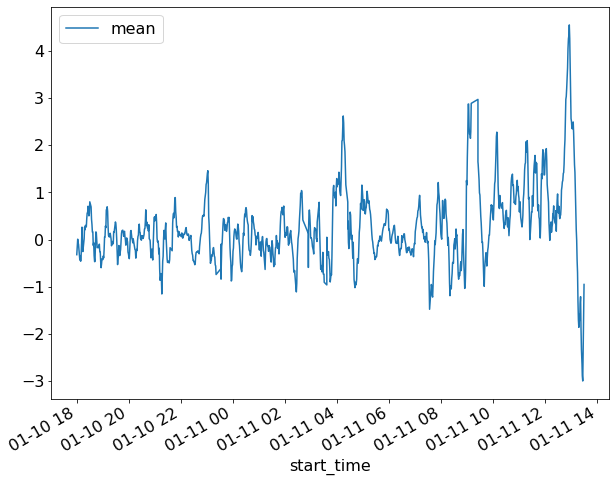

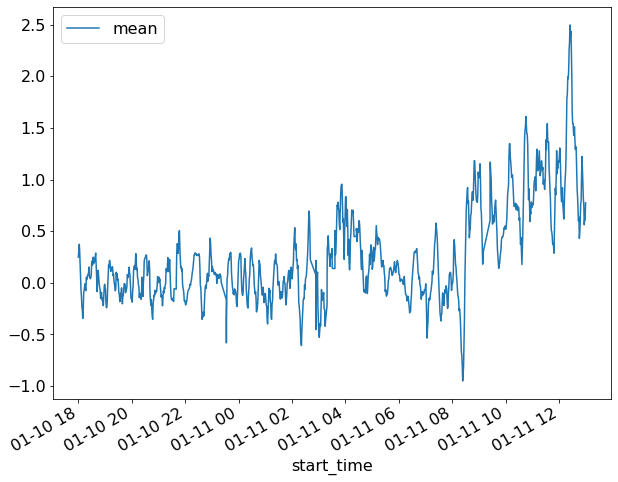

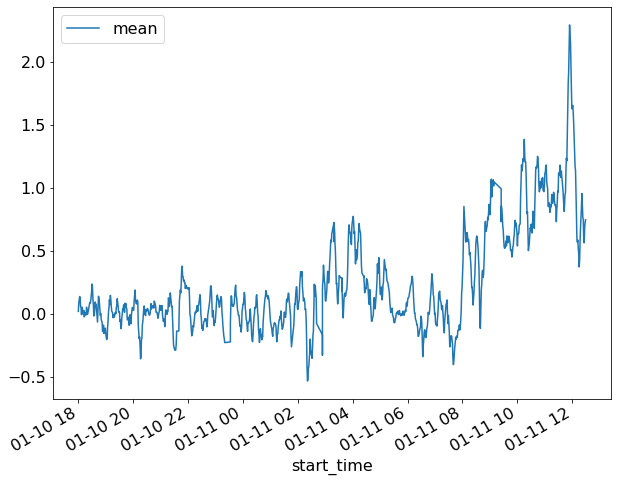

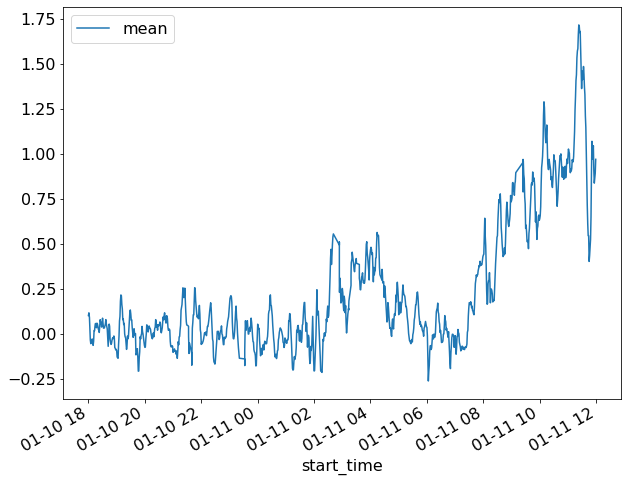

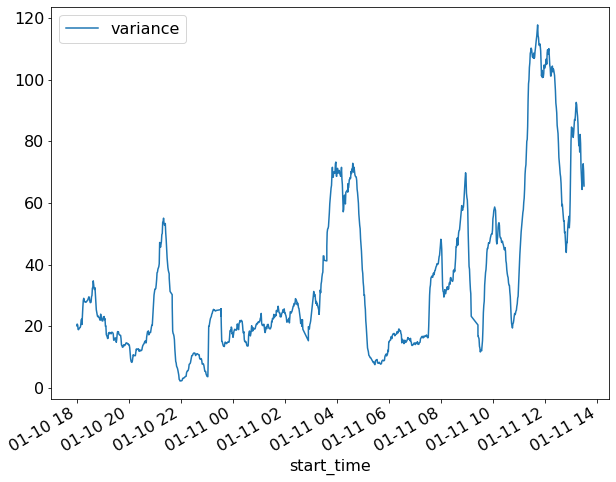

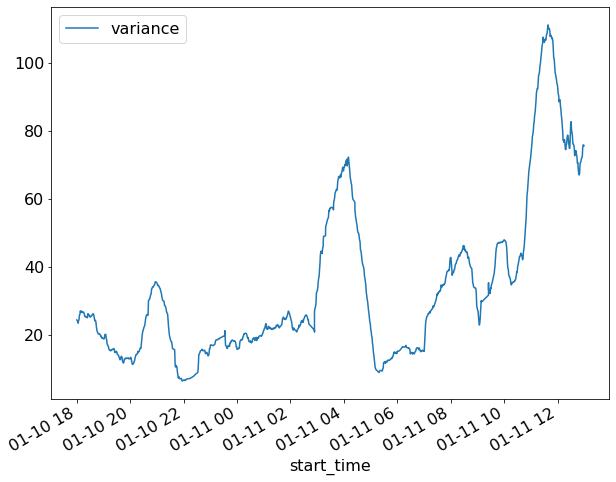

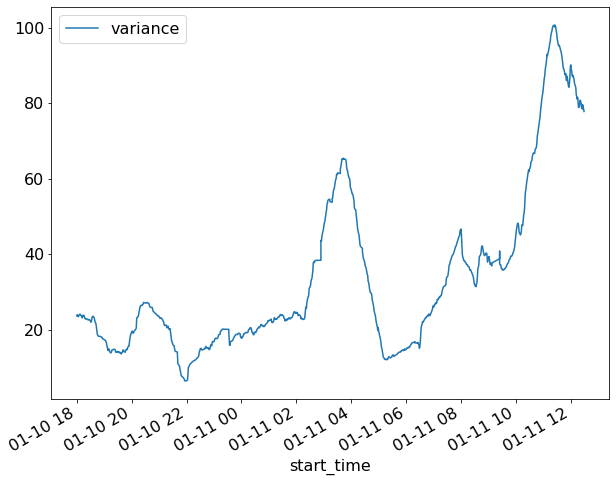

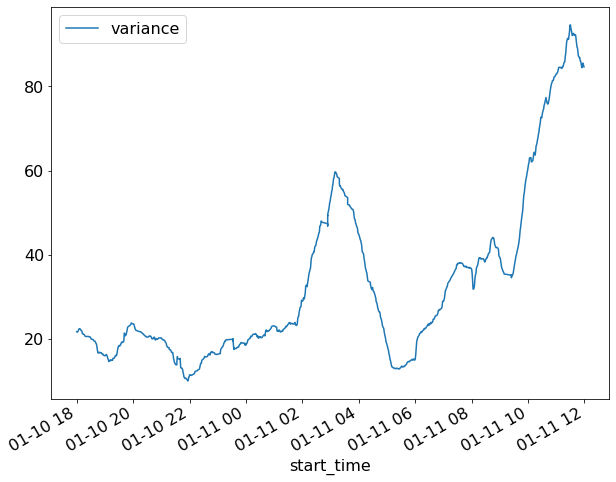

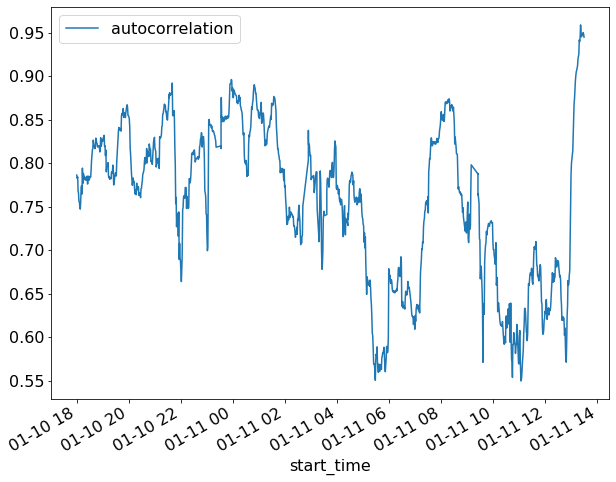

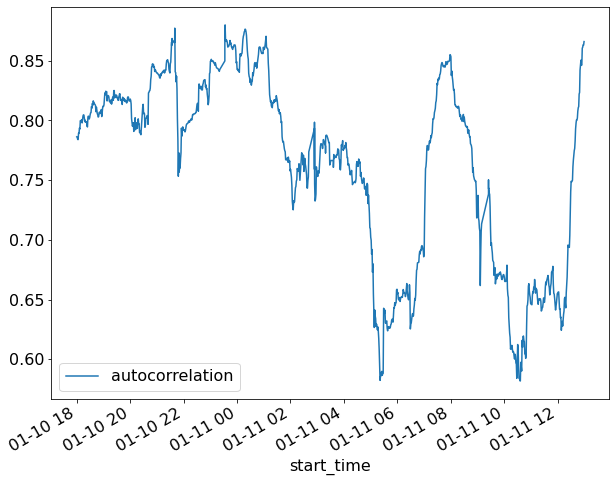

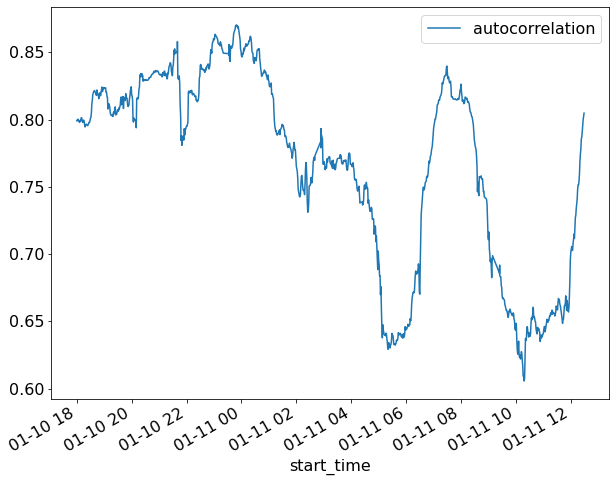

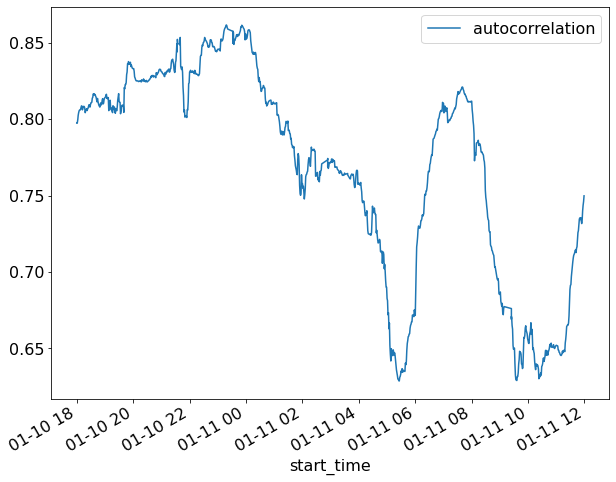

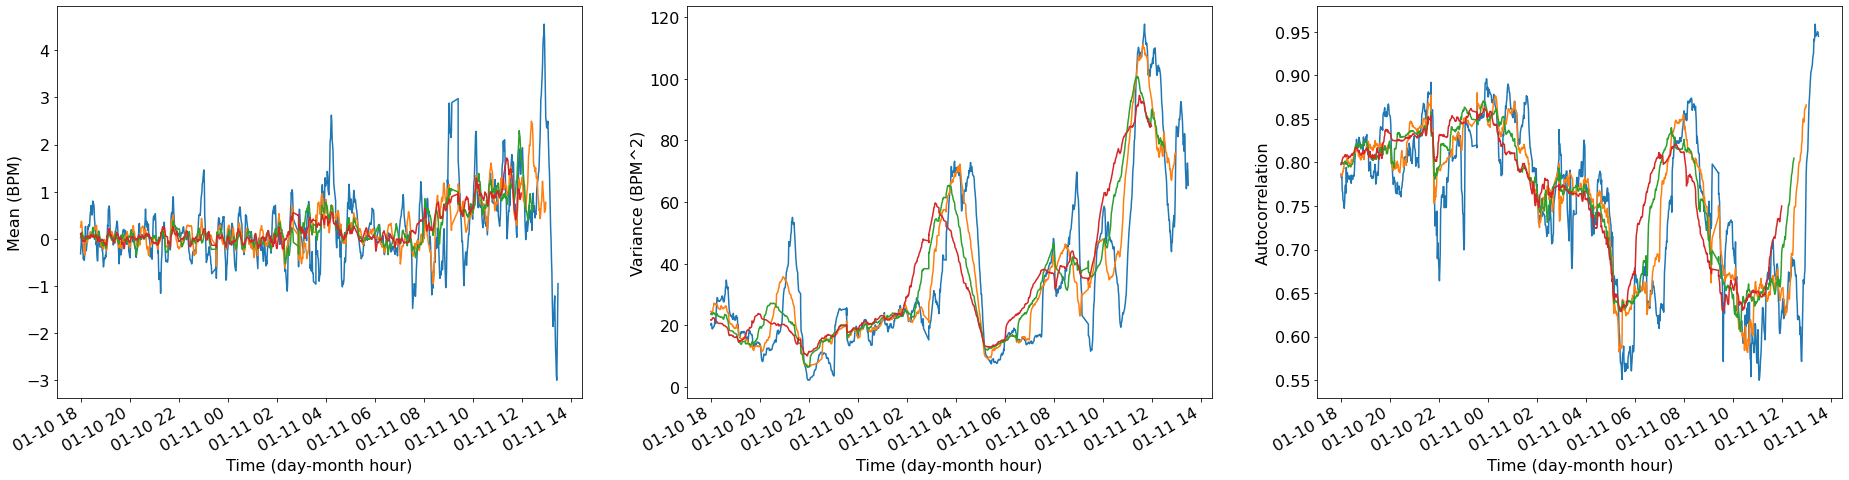

In [61]:
graph_grid(rolling_mean, PC_0192_RR_residuals_no_anomalies, 30, 60, 90, 120, "mean")